# **'Where's Wally' with Machine Learning: Phase  2 - Partial R-CNN**

In [ ]:
# ==== PyTorch Core ====
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# ==== TorchVision ====
import torchvision.models as models
from torchvision import transforms, ops
from torchvision.datasets import CocoDetection
import torchvision.transforms.functional as F

# ==== Region Proposal Tools ====
import selectivesearch

# ==== Roboflow ====
from roboflow import Roboflow

# ==== Visualization ====
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ==== Image Processing & Utilities ====
from PIL import Image
import numpy as np
import random
import os
import json


### Load in API dataset

In [2]:
rf = Roboflow(api_key="iE53lBCUXtDffBO8i7dk")
project = rf.workspace("tan-rmi").project("whereiswaldo-ssmol")
version = project.version(3)
dataset = version.download("coco")
print(dataset.location)

loading Roboflow workspace...
loading Roboflow project...
c:\Users\alici\OneDrive - Swansea University\Dissertation\Diss\WhereIsWaldo-3


### Preprocess dataset function

In [3]:
class PreprocessedCocoDataset(CocoDetection):
    def __getitem__(self, index):
        image, target = super().__getitem__(index)  # Load image & annotations

        # Original image size
        width, height = image.size  

        # Reduce dimensions by 5%
        scale_factor = 0.95
        new_width, new_height = int(width * scale_factor), int(height * scale_factor)

        # Resize image
        image = image.resize((new_width, new_height), Image.LANCZOS)

        # Reduce RGB colors (keep ~32 colors)
        image = image.quantize(colors=32).convert("RGB")

        # Scale bounding boxes
        for obj in target:
            x1, y1, w, h = obj['bbox']  # COCO format (x, y, w, h)
            x1 = int(x1 * scale_factor)
            y1 = int(y1 * scale_factor)
            w = int(w * scale_factor)
            h = int(h * scale_factor)
            obj['bbox'] = [x1, y1, w, h]  # Update bounding box

        # Apply transformations only to the image
        if self.transforms:
            image = self.transforms(image)  # Apply additional transformations (normalize, tensor, etc.)

        return image, target


### Data is loaded in and preprocessed

In [ ]:
dataset_path = "C:/Users/alici/OneDrive - Swansea University/Dissertation/WhereIsWaldo.v3i.coco"
train_images = os.path.join(dataset_path, "train")
train_annotations = os.path.join(dataset_path, "train", "_annotations.coco.json")

val_images = os.path.join(dataset_path, "valid")
val_annotations = os.path.join(dataset_path, "valid", "_annotations.coco.json")

test_images = os.path.join(dataset_path, "test")
test_annotations = os.path.join(dataset_path, "test", "_annotations.coco.json")


train_dataset = PreprocessedCocoDataset(root=train_images, annFile=train_annotations)
val_dataset = PreprocessedCocoDataset(root=val_images, annFile=val_annotations)
test_dataset = PreprocessedCocoDataset(root=test_images, annFile=test_annotations)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=2)

print('-' * 60)
print(f"Train samples: {len(train_dataset)}")
print('-' * 60)
print(f"Validation samples: {len(val_dataset)}")
print('-' * 60)
print(f"Test samples: {len(test_dataset)}")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
------------------------------------------------------------
Train samples: 440
------------------------------------------------------------
Validation samples: 88
------------------------------------------------------------
Test samples: 42


#### Visual example with ground truth bounding box

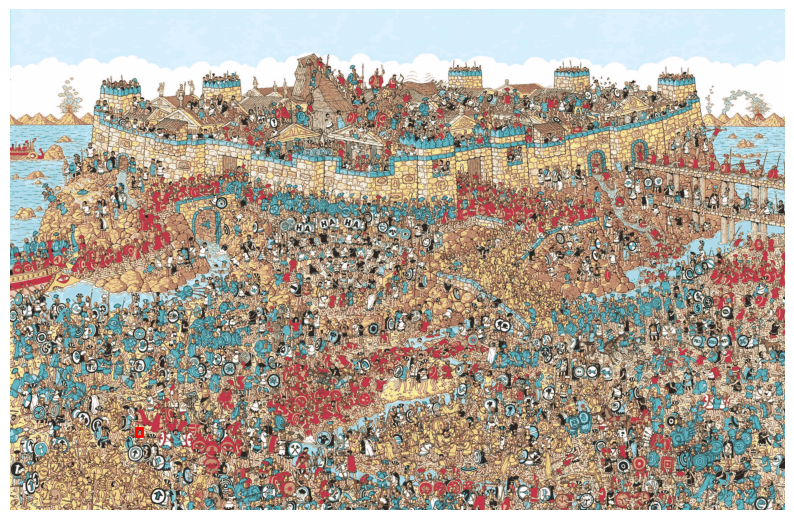

In [5]:
def show_sample(dataset, index=0):
    img, annotation = dataset[index]

    # If the image is a tensor, convert it to a numpy array
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
        img = (img * 255).astype(np.uint8)  # If the image is normalized, bring it back to 0-255 range

    # If the image is in PIL format, convert it to numpy
    elif isinstance(img, Image.Image):
        img = np.array(img)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)

    # Draw bounding boxes
    for ann in annotation:
        x, y, w, h = ann['bbox']
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis("off")
    plt.show()

show_sample(train_dataset, index=45)

### Selective search function

In [7]:
def apply_selective_search(image):
    _, regions = selectivesearch.selective_search(image, scale=250, min_size=10)

    proposals = []
    seen_rects = set() 

    for region in regions:
        rect = region['rect'] 

        if rect in seen_rects:
            continue
        seen_rects.add(rect)

        x, y, w, h = rect
        if w < 20 or h < 20:  
            continue  

        proposals.append(rect)

    return proposals


#### Selective search on test image

Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.


Number of proposals: 1735


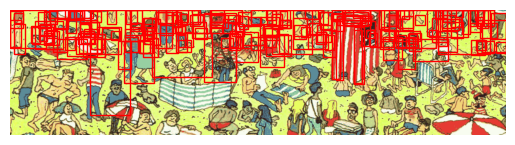

In [8]:
image_pil, _ = train_dataset[1]
img_tensor = F.to_tensor(image_pil)
image = img_tensor.permute(1, 2, 0).numpy() 

proposals = apply_selective_search(image)
print(f"Number of proposals: {len(proposals)}")

plt.imshow(image)
for (x, y, w, h) in proposals[:200]:
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='r', fill=False, linewidth=1))

plt.axis('off')
plt.show()

In [9]:
image.shape

(343, 1358, 3)

In [11]:
annotation_file = os.path.join(dataset_path, "train", "_annotations.coco.json")

with open(annotation_file, "r") as f:
    data = json.load(f)

annotations = data.get("annotations", [])

wally_bbox = None

for ann in annotations:
    if ann.get("category_id") == 1:
        wally_bbox = ann.get("bbox")
        break

if wally_bbox:
    wally_bbox = (wally_bbox[0], wally_bbox[1], wally_bbox[0] + wally_bbox[2], wally_bbox[1] + wally_bbox[3])
    print("Wally's Bounding Box:", wally_bbox)
else:
    print("Wally's bounding box not found!")

Wally's Bounding Box: (745, 777, 772, 808)


In [12]:
# print(f"Waldo Bounding Box: {wally_bbox}")
# print(f"Total proposals generated: {len(proposals)}")
# for i, (x, y, w, h) in enumerate(proposals[:50]):
#     print(f"Proposal {i}: {(x, y, x+w, y+h)}")


#### Convert COCO format into xyxy format

In [13]:
def coco_to_xyxy(box):
    x, y, w, h = box
    return (x, y, w + x, h + y)

### Apply selective search on training images

In [14]:
results = []
num_samples = 1
training_samples = random.sample(range(len(train_dataset)), num_samples)

for i in training_samples:
    image_pil, annotations = train_dataset[i]
    width, height = image_pil.size
    print(f"Processing Image {training_samples.index(i)+1}/{len(training_samples)} - Size: {width}x{height}")

    gt_boxes = [coco_to_xyxy(ann["bbox"]) for ann in annotations]
    print(f"Ground Truth Bounding Boxes: {gt_boxes}")

    image_np = np.array(image_pil)
    proposals = apply_selective_search(image_np)
    print(f"Total proposals: {len(proposals)}")

    results.append({
        "image_id": i,
        "gt_boxes": gt_boxes,
        "proposals": proposals
    })

np.save('results.npy', results)

Processing Image 1/1 - Size: 1515x1293
Ground Truth Bounding Boxes: [(807, 649, 832, 678)]
Total proposals: 4990


### Compute the IoU

In [15]:
gt_boxes_tensor = torch.tensor(gt_boxes, dtype=torch.float32)
iou_values = []

for proposal in proposals:
    proposal_xyxy = torch.tensor(coco_to_xyxy(proposal), dtype=torch.float32).unsqueeze(0)

    iou = ops.box_iou(gt_boxes_tensor, proposal_xyxy)

    max_iou = iou.max().item()

    if max_iou:
        print(f"IoU: {max_iou}")
        iou_values.append(max_iou)
        print("Decent proposal found!")

IoU: 0.013715540058910847
Decent proposal found!
IoU: 0.046755339950323105
Decent proposal found!
IoU: 0.043237484991550446
Decent proposal found!
IoU: 0.49900200963020325
Decent proposal found!
IoU: 0.34578147530555725
Decent proposal found!
IoU: 0.4334600865840912
Decent proposal found!
IoU: 0.11082307249307632
Decent proposal found!
IoU: 0.010393739677965641
Decent proposal found!
IoU: 0.0072828843258321285
Decent proposal found!
IoU: 0.039017826318740845
Decent proposal found!
IoU: 0.004446676466614008
Decent proposal found!
IoU: 0.0038432322908192873
Decent proposal found!
IoU: 0.28165534138679504
Decent proposal found!
IoU: 0.003831141395494342
Decent proposal found!
IoU: 0.007775632664561272
Decent proposal found!
IoU: 0.038164172321558
Decent proposal found!
IoU: 0.003537951735779643
Decent proposal found!
IoU: 0.003385386196896434
Decent proposal found!
IoU: 0.004772813990712166
Decent proposal found!
IoU: 0.026336701586842537
Decent proposal found!
IoU: 0.025083793327212334
D

<!-- IoU: 0.0023265595227248428
Decent proposal found!
IoU: 0.015077989820484911
Decent proposal found!
IoU: 0.02583111349354341
Decent proposal found!
IoU: 0.06015002843666607
Decent proposal found!
IoU: 0.09366832535885171
Decent proposal found!
IoU: 0.0870719644180875
Decent proposal found!
IoU: 0.0612090046899427
Decent proposal found!
IoU: 0.05384125412541256
Decent proposal found!
IoU: 0.030910547368421065
Decent proposal found!
IoU: 0.02508973000683528
Decent proposal found!
IoU: 0.008175449480663897
Decent proposal found!
IoU: 0.021347063099738304
Decent proposal found!
IoU: 0.01110418735646649
...
IoU: 0.002757796769346357
Decent proposal found!
IoU: 0.0019187744420594555
Decent proposal found!
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings... -->

#### Visualise IoU's

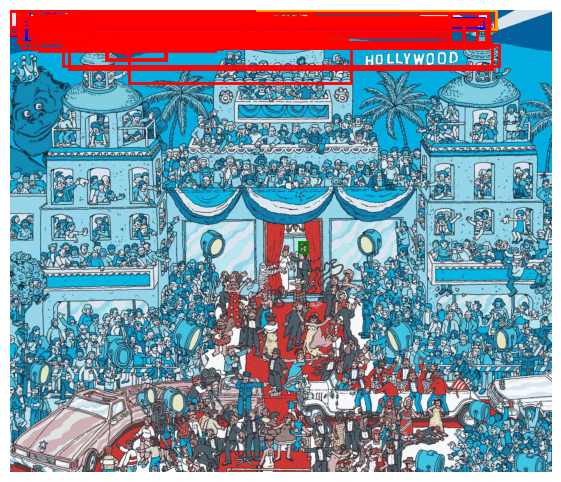

In [16]:
def visualise_iou(image_pil, gt_boxes, proposals, iou_values):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.imshow(image_pil)

    for gt_box in gt_boxes:
        x1, y1, x2, y2 = gt_box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2  - y1, linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect)

    for (proposal, iou) in zip(proposals, iou_values):
        x1, y1, x2, y2 = proposal

        if iou > 0.1:
            color = 'blue'
        elif iou > 0.06:
            color = 'orange'
        else:
            color = 'red'

        rect = patches.Rectangle((x1, y1), x2 - x1, y2  - y1, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

visualise_iou(image_pil, gt_boxes, proposals, iou_values)

In [17]:
# iou_threshold = 0.05
# good_proposals = [proposal for proposal, iou in zip(proposals, iou_values) if iou > iou_threshold]

### Feature extraction with Resnet50 functiom

In [18]:
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet_fe = torch.nn.Sequential(*(list(resnet.children())[:-2]))
resnet.eval()

def extract_features(image, proposals, model):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    features = []
    for box in proposals:
        x1, y1, x2, y2 = map(int, box)
        
        x1, x2 = min(x1, x2), max(x1, x2)
        y1, y2 = min(y1, y2), max(y1, y2)

        cropped_region = image.crop((x1, y1, x2, y2))  # Crop proposal
        tensor_region = transform(cropped_region).unsqueeze(0)  # Add batch dimension
        feature = model(tensor_region)  # Extract features
        print(feature.shape)
        features.append(feature.squeeze().detach().numpy())

    return np.array(features)

proposal_features = extract_features(image_pil, proposals, resnet_fe)
# print("Feature array shape:", proposal_features.shape)
print("Feature array contents:", proposal_features)


torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2048,

In [19]:
print(proposal_features.shape)

(4990, 2048, 7, 7)


In [20]:
X_train = [] # images
y_train = [] # labels

# Got to check now cause I dont know how'd they'd even be the same
if len(proposal_features) != len(iou_values):
    print(f"MISMATCH! Features: {len(proposal_features)}, IoUs: {len(iou_values)}")

for feature, iou in zip(proposal_features, iou_values):  # Zip so they match
    if iou > 0.5:
        label = 1  # Wally
    elif iou < 0.3:
        label = 0  # Background
    else:
        continue  # Skip ambiguous cases

    X_train.append(feature)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)
print("Training Data Shape:", X_train.shape, "Labels Shape:", y_train.shape)


MISMATCH! Features: 4990, IoUs: 88
Training Data Shape: (83, 2048, 7, 7) Labels Shape: (83,)
